Практикум «Ассинхронный Python 3, многопоточность Python 3 в изучении  платежных систем и криптовалюты России»

# 🧠 Модуль 1. Асинхронный Python


## 1. Введение: платежные системы РФ и криптовалюта
**Теория:**

Основные платежные системы в России: Сбербанк, Тинькофф, ВТБ, МИР, Visa/Mastercard, Система быстрых платежей (СБП), электронные деньги (ЮMoney, Qiwi и др.), перевод через банки.

Основные принципы работы: платежные шлюзы, эквайринг, расчётные банки, межбанковские системы (ЦБ РФ), комиссия, расчётный период.

Правовой статус криптовалюты в России: что разрешено/запрещено (например, разрешена торговля, но не как средство платежа внутри РФ)

Риски: волатильность, мошенничество, регулирование (KYC, AML), технологические уязвимости.

Возможные модели гибридных систем: обменники, мосты, агрегаторы, P2P, клиентские приложения.
Демонстрационный проект — макет обменника (skeleton):

Написать синхронный модуль exchange.py, который:
запрашивает курсы криптовалют (например, через API CoinGecko или Binance REST API),
получает курсы рубль ↔ крипто и обратно,
обрабатывает запрос “купить / продать” с базовой логикой (например, комиссия, минимальный объём),
генерирует ответ (успех / ошибка).
Это позволит студентам сразу увидеть, что будет асинхронно ускоряться дальше.

## 2. Основы асинхронного программирования, Awaitable, Event Loop

**Теория:**

Что такое корутина (coroutine), awaitable объекты, await / async.
Как Python интерпретирует async def, как корутина “приостанавливает” выполнение, как возвращается управление event loop.
Event Loop: запуск корутин, планирование, переключение контекстов.
Отличие от потоков: нет GIL-проблемы для I/O, нет переключения через preemption.
Когда стоит применять асинхронность: задачи, где большинство времени уходит на I/O (сетевые запросы, файловые операции).

Пример кода + задача:


In [ ]:
import asyncio
import time

async def do_wait(n: int):
    print(f"Start waiting {n}")
    await asyncio.sleep(n)
    print(f"Done waiting {n}")
    return n

async def main():
    start = time.perf_counter()
    result1 = await do_wait(2)
    result2 = await do_wait(3)
    total = result1 + result2
    end = time.perf_counter()
    print("Sequential total:", total, "Time:", end - start)

    start2 = time.perf_counter()
    a, b = await asyncio.gather(do_wait(2), do_wait(3))
    print("Gather results:", a + b)
    end2 = time.perf_counter()
    print("Parallel time:", end2 - start2)

# In a Colab environment, an event loop is usually already running.
# We can directly await the main coroutine.
await main()

Start waiting 2
Done waiting 2
Start waiting 3
Done waiting 3
Sequential total: 5 Time: 5.006075858999964
Start waiting 2
Start waiting 3
Done waiting 2
Done waiting 3
Gather results: 5
Parallel time: 3.002294811000013


Объяснения:
В первой части корутины выполняются последовательно: do_wait(2) ждёт, затем do_wait(3).
Во второй части asyncio.gather запускает их “параллельно” (кооперативно): время ≈ max(2,3) вместо суммы.
Это демонстрирует выигрыш от асинхронности.

3. Задачи / Task, gather / wait, отмена задач
Теория:
asyncio.create_task(), asyncio.ensure_future() — создание задач (Task), которые начинают выполняться в фоне.
asyncio.gather(), asyncio.wait() и их различия (wait возвращает set завершённых, gather возвращает результаты / бросит исключение, если одна coroutine упадёт).
Отмена задач: task.cancel(), ловля asyncio.CancelledError.
Обработка исключений внутри задач, таймауты (asyncio.wait_for).

Задача:
Симулировать множество “клиентов”, которые отправляют запросы котировок к API с задержками:
Пусть есть список URL-адресов API (или заглушек), некоторые из них медленные, некоторые быстрые, некоторые возвращают ошибку.
Запустить множество задач, контролировать таймаут на каждый запрос (например, 3 секунды).
Обработать успешные ответы и исключения, собрать статистику: сколько успешно, сколько упало, сколько таймаутов.
Набросок решения:


In [ ]:
import asyncio
import random

async def fetch_fake(name: str):
    delay = random.uniform(0.5, 5.0)
    await asyncio.sleep(delay)
    if delay > 4.0:
        raise RuntimeError(f"{name} too slow")
    return f"{name} result in {delay:.2f}s"

async def handle_one(name: str):
    try:
        res = await asyncio.wait_for(fetch_fake(name), timeout=3.0)
        print(f"Success {name}: {res}")
        return res
    except asyncio.TimeoutError:
        print(f"Timeout {name}")
    except Exception as e:
        print(f"Error {name}: {e}")

async def main():
    names = [f"api_{i}" for i in range(10)]
    tasks = [asyncio.create_task(handle_one(n)) for n in names]
    results = await asyncio.gather(*tasks, return_exceptions=True)
    print("All done:", results)

await main()

Success api_0: api_0 result in 0.56s
Success api_7: api_7 result in 1.02s
Success api_1: api_1 result in 1.70s
Success api_2: api_2 result in 2.05s
Success api_8: api_8 result in 2.14s
Success api_6: api_6 result in 2.80s
Timeout api_3
Timeout api_4
Timeout api_5
Timeout api_9
All done: ['api_0 result in 0.56s', 'api_1 result in 1.70s', 'api_2 result in 2.05s', None, None, None, 'api_6 result in 2.80s', 'api_7 result in 1.02s', 'api_8 result in 2.14s', None]


Объяснение:
Используется wait_for для ограничения времени ожидания.
gather(..., return_exceptions=True) позволяет собрать все результаты, даже если часть задач упала.

4. Проблемы синхронизации, очереди в asyncio, базовые примитивы
Теория:
Когда несколько задач должны совместно работать с общим ресурсом или разделять нагрузку → нужна синхронизация.
Примитивы в asyncio: Lock, Event, Semaphore, BoundedSemaphore, Condition.
Очереди asyncio.Queue: безопасный механизм передачи данных между корутинами.
Использование очередей — хорошая модель производитель-потребитель.

Задача: обменник с ограничением одновременных заявок

Модель:
есть очередь заявок asyncio.Queue, в которую поступают заявки от клиентов (имя, тип “buy”/“sell”, сумму).
есть пул “работников” — корутин, которые берут заявки из очереди и обрабатывают (запрос к API, вычисление курса, запись результата).
ограничить число одновременно работающих задач (например, максимум 5) через Semaphore или через просто число рабочих корутин.
обеспечить graceful shutdown: ждать пока очередь не опустеет, завершить задачи.
Набросок решения:


In [ ]:
import asyncio
import random

async def worker(name: str, queue: asyncio.Queue, sem: asyncio.Semaphore):
    while True:
        job = await queue.get()
        if job is None:  # сигнал завершения
            queue.task_done()
            break
        async with sem:
            print(f"Worker {name} handling {job}")
            # симуляция обработки
            await asyncio.sleep(random.uniform(0.5, 2.0))
            print(f"Worker {name} done {job}")
        queue.task_done()

async def main():
    queue = asyncio.Queue()
    sem = asyncio.Semaphore(3)  # макс одновременно 3 обработки
    workers = [asyncio.create_task(worker(f"w{i}", queue, sem)) for i in range(5)]

    # добавим задания
    for i in range(20):
        await queue.put(f"job_{i}")

    # подождём, пока все задания обработаны
    await queue.join()

    # послать сигнал завершения
    for _ in workers:
        await queue.put(None)
    await asyncio.gather(*workers)
    print("All done")

await main()

Worker w0 handling job_0
Worker w1 handling job_1
Worker w2 handling job_2
Worker w1 done job_1
Worker w3 handling job_3
Worker w0 done job_0
Worker w4 handling job_4
Worker w2 done job_2
Worker w1 handling job_5
Worker w4 done job_4
Worker w0 handling job_6
Worker w3 done job_3
Worker w2 handling job_7
Worker w0 done job_6
Worker w4 handling job_8
Worker w1 done job_5
Worker w3 handling job_9
Worker w3 done job_9
Worker w0 handling job_10
Worker w2 done job_7
Worker w1 handling job_11
Worker w4 done job_8
Worker w3 handling job_12
Worker w1 done job_11
Worker w2 handling job_13
Worker w0 done job_10
Worker w4 handling job_14
Worker w3 done job_12
Worker w1 handling job_15
Worker w2 done job_13
Worker w0 handling job_16
Worker w1 done job_15
Worker w3 handling job_17
Worker w4 done job_14
Worker w2 handling job_18
Worker w3 done job_17
Worker w1 handling job_19
Worker w2 done job_18
Worker w0 done job_16
Worker w1 done job_19
All done



Объяснение:
queue.join() ждёт, пока все task_done() вызваны.
Рабочие смотрят на None как сигнал завершения.
Semaphore ограничивает число одновременных “обработок”.

5. Аiofiles: асинхронная работа с файлами
Теория:
Стандартные open/read/write блокирующие — плохо в асинхронном коде.
Библиотека aiofiles позволяет читать/писать файлы асинхронно через await.
Поддерживает async with aiofiles.open(...) и методы read(), write(), readline(), seek(), и т.д.
Задача: логирование операций обмена
При обработке заявки записывать результаты в файл JSON/CSV (например, время, тип, курс, сумма, статус).
Делать это асинхронно, не блокируя основной цикл.
При завершении работы выгрузить итоговый файл.
Пример:


In [ ]:
import asyncio
import aiofiles
import json
import random
import time

async def log_transaction(logfile: str, rec: dict):
    async with aiofiles.open(logfile, mode='a') as f:
        line = json.dumps(rec, ensure_ascii=False)
        await f.write(line + "\n")

async def simulate_transactions(logfile: str, n: int):
    for i in range(n):
        rec = {
            "timestamp": time.time(),
            "id": i,
            "type": random.choice(["buy", "sell"]),
            "amount": random.uniform(0.1, 5.0),
            "status": random.choice(["ok", "fail"])
        }
        await log_transaction(logfile, rec)
        await asyncio.sleep(0.1)

async def main():
    await simulate_transactions("transactions.log", 20)
    print("Done logging")

await main()

Done logging


6. Клиент-сервер через aiohttp
Теория:
aiohttp поддерживает и клиентскую часть (ClientSession) и серверную часть (aiohttp.web).
Клиентская часть: делать HTTP-запросы асинхронно, использовать сессии (connection pooling)
Серверная часть: определение маршрутов, обработчиков, middlewares, JSON обработка.
Задача: простой REST-API обменника
Сервер (на localhost) предоставляет:
GET /rate?pair=BTC_RUB — возвращает текущий курс,
POST /exchange — принимает JSON с запросом обмена (тип, сумма), возвращает статус, рассчитанную сумму, комиссия.
Клиентская часть (отдельный скрипт) отправляет запросы асинхронно к серверу: множество параллельных заявок, собирает ответы, выводит статистику.
Набросок сервера:


In [ ]:
from aiohttp import web
import json
import random

routes = web.RouteTableDef()

@routes.get('/rate')
async def get_rate(request):
    pair = request.query.get("pair", "BTC_RUB")
    # генерация "курса"
    rate = random.uniform(2e6, 3e6)  # пример: 1 BTC = 2–3 млн руб
    return web.json_response({"pair": pair, "rate": rate})

@routes.post('/exchange')
async def post_exchange(request):
    data = await request.json()
    typ = data.get("type")  # "buy"/"sell"
    amount = data.get("amount")
    pair = data.get("pair", "BTC_RUB")
    # простая логика: курс, комиссия
    rate = random.uniform(2e6, 3e6)
    commission = 0.005  # 0.5%
    if typ == "buy":
        result = amount / rate * (1 - commission)
    else:
        result = amount * rate * (1 - commission)
    return web.json_response({"status": "ok", "result": result, "commission": commission, "rate": rate})

app = web.Application()
app.add_routes(routes)

# The server part `web.run_app` is commented out because it blocks the cell
# and conflicts with Colab's event loop. For a full client-server interaction,
# the server would need to run in a separate process or environment.
# if __name__ == "__main__":
#     web.run_app(app, port=8080)

# Набросок клиента:

import asyncio
import aiohttp
import random

async def make_exchange(session: aiohttp.ClientSession, typ: str, amount: float):
    payload = {"type": typ, "amount": amount, "pair": "BTC_RUB"}
    async with session.post("http://localhost:8080/exchange", json=payload) as resp:
        return await resp.json()

async def main():
    async with aiohttp.ClientSession() as session:
        tasks = []
        for i in range(20):
            typ = random.choice(["buy", "sell"])
            amt = random.uniform(0.1, 10.0)
            tasks.append(make_exchange(session, typ, amt))
        results = await asyncio.gather(*tasks, return_exceptions=True)
        for r in results:
            print(r)

# In a Colab environment, an event loop is usually already running.
# We can directly await the main coroutine for the client part.
await main()

404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='http://localhost:8080/exchange'
404, message='Attempt to decode JSON with unexpected mimetype: ', url='ht

Комментарий:
Сервер — минимальный, подчёркивает маршрутизацию, JSON.
Клиент — множество параллельных запросов, сбор ответов.
Можно расширять: валидация, баланс пользователей, очереди, журналирование.

7. Интеграция с криптовалютами: API и библиотека
Теория / Контекст:
Различные публичные API (CoinGecko, Binance, etc.) предоставляют курсы и данные через HTTP / WebSocket.
Библиотеки для взаимодействия с блокчейнами (например, web3.py для Ethereum, библиотеки bitcoinlib, bit для Bitcoin) запрещают или разрешают создание аккаунтов, управление приватными ключами, подписание транзакций, отправку.
Для безопасности: приватные ключи нельзя хранить в открытом виде, использовать тестовые сети (testnet), не хранить реальные средства в процессе упражнений.
В условиях РФ нужно помнить об ограничениях на приём/платеж криптовалютой внутри страны (внутренние транзакции криптовалютами могут быть запрещены).
Задача: создать «крипто-модуль» и использовать его в обменнике
Модуль crypto_client.py:
генерирует приватный/публичный ключ (для testnet),
получает баланс,
создаёт и подписывает транзакции,
отправляет транзакции на публичный узел (например, через Infura, или публичный тестовый Bitcoin node API).
В рамках обменника: запрос курса, проверка баланса, отправка криптовалюты после подтверждения.
Пример (Bitcoin testnet, с библиотекой bit):


Можно “обернуть” это в асинхронный интерфейс (оболочку), вызывая методы с run_in_executor, т.к. многие такие библиотеки синхронны.

Ссылки, библиография и ресурсы
Документация и туториалы:
aiohttp — официальная документация клиента/сервера
Hands-on Intro to aiohttp / Intro to asyncio (PyCon)
«Asynchronous HTTP Requests in Python with aiohttp» (Twilio blog)
Биржевые и крипто-туториалы: “How to Build a Crypto Arbitrage Bot”
“How to make a Bitcoin transaction with Python”
Статьи по паттернам платежных приложений на блокчейне
Обзор крипторегуляции в России (DisruptionBanking)
Дополнительные статьи / научные работы:
“Patterns for Blockchain-Based Payment Applications”
“FastPay: High-Performance Byzantine Fault Tolerant Settlement”
“Zef: Low-latency, Scalable, Private Payments”

🧠 МОДУЛЬ 2. Многопоточный Python

Тема практикума: Оптимизация обработки транзакций и криптоопераций с помощью многопоточности и мультипроцессинга
Цель:
Научиться использовать потоки и процессы Python для ускорения обработки параллельных задач — запросов к платёжным шлюзам, расчётов комиссий, логирования, агрегации данных и т.п.

Инструменты:
threading, concurrent.futures, queue, multiprocessing, time, random, matplotlib, pandas.

---

1️⃣ Введение в многопоточность

Теоретическое введение

Многопоточность — способ организации выполнения кода, при котором несколько потоков (threads) выполняются в одном процессе и могут совместно использовать память.
Подходит для задач с высокой долей I/O операций: сетевые запросы, работа с файлами, логирование, API-вызовы.

---

🧩 Задание 1. Моделирование параллельных платёжных операций
Код:


In [ ]:
import threading
import time
import random

def process_payment(transaction_id):
    print(f"🧾 Обработка транзакции {transaction_id} начата")
    time.sleep(random.uniform(1, 3))  # имитация задержки API
    print(f"✅ Транзакция {transaction_id} завершена")

threads = []
for i in range(5):
    t = threading.Thread(target=process_payment, args=(i,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

print("💰 Все платежи обработаны!")

🧾 Обработка транзакции 0 начата
🧾 Обработка транзакции 1 начата
🧾 Обработка транзакции 2 начата
🧾 Обработка транзакции 3 начата
🧾 Обработка транзакции 4 начата
✅ Транзакция 0 завершена
✅ Транзакция 4 завершена
✅ Транзакция 2 завершена
✅ Транзакция 3 завершена
✅ Транзакция 1 завершена
💰 Все платежи обработаны!


Комментарии:
Каждый поток моделирует независимую транзакцию.
join() гарантирует, что программа ждёт завершения всех потоков.
Вывод:
Многопоточность эффективна, когда множество операций ожидают ответов от внешних API или сетевых систем.

2️⃣ Работа с пулами потоков (ThreadPoolExecutor)
Теория
Класс ThreadPoolExecutor из concurrent.futures позволяет запускать множество задач с управлением пула потоков — это удобнее и безопаснее, чем вручную создавать потоки.
---

🧩 Задание 2. Получение курсов валют с нескольких источников
Код:


3️⃣ Подробнее о Future — объект будущего результата
🧩 Задание 3. Мониторинг выполнения задач в реальном времени
Код:


In [ ]:
from concurrent.futures import ThreadPoolExecutor
import random
import time

def simulate_api_call(api_name):
    duration = random.uniform(1, 4)
    time.sleep(duration)
    return f"{api_name} ответил за {duration:.2f} сек"

apis = ["СБП", "Мир", "Visa", "MasterCard"]

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(simulate_api_call, api): api for api in apis}
    for future in futures:
        api = futures[future]
        print(f"📤 Запущен запрос к {api}")

    for future in futures:
        print("🔔", future.result())

📤 Запущен запрос к СБП
📤 Запущен запрос к Мир
📤 Запущен запрос к Visa
📤 Запущен запрос к MasterCard
🔔 СБП ответил за 2.98 сек
🔔 Мир ответил за 2.69 сек
🔔 Visa ответил за 2.85 сек
🔔 MasterCard ответил за 3.51 сек


Комментарии:
Future представляет отложенный результат задачи.
Можно получать статус, отменять задачу, проверять завершение.
Вывод:
Future помогает отслеживать жизненный цикл задач, как в реальных процессинговых системах.

4️⃣ Потокобезопасные очереди (queue.Queue)
🧩 Задание 4. Многопоточная обработка заявок
Код:


In [ ]:
import threading
import queue
import time
import random

def worker(q):
    while True:
        try:
            tx = q.get(timeout=2)
        except queue.Empty:
            break
        print(f"{threading.current_thread().name} обрабатывает {tx}")
        time.sleep(random.uniform(1, 2))
        q.task_done()

q = queue.Queue()
for i in range(10):
    q.put(f"txn_{i}")

threads = [threading.Thread(target=worker, args=(q,)) for _ in range(3)]
for t in threads:
    t.start()
for t in threads:
    t.join()

print("✅ Все заявки обработаны.")

Thread-11 (worker) обрабатывает txn_0
Thread-12 (worker) обрабатывает txn_1
Thread-13 (worker) обрабатывает txn_2
Thread-13 (worker) обрабатывает txn_3
Thread-12 (worker) обрабатывает txn_4
Thread-11 (worker) обрабатывает txn_5
Thread-12 (worker) обрабатывает txn_6
Thread-13 (worker) обрабатывает txn_7
Thread-11 (worker) обрабатывает txn_8
Thread-12 (worker) обрабатывает txn_9
✅ Все заявки обработаны.


Вывод:
Очередь гарантирует безопасность данных между потоками — ключевой элемент при обработке очередей транзакций.

5️⃣ Управление потоками и синхронизация (Lock, Event, Semaphore)
🧩 Задание 5. Контроль доступа к счёту клиента
Код:


In [ ]:
import threading
import random
import time

balance = 10000
lock = threading.Lock()

def update_balance(name):
    global balance
    for _ in range(5):
        with lock:
            delta = random.randint(-1000, 1000)
            balance += delta
            print(f"{name} изменил баланс на {delta:+}, итого: {balance}")
        time.sleep(random.uniform(0.5, 1))

threads = [threading.Thread(target=update_balance, args=(f"Поток-{i}",)) for i in range(3)]
for t in threads:
    t.start()
for t in threads:
    t.join()

print("💰 Итоговый баланс:", balance)


Поток-0 изменил баланс на -412, итого: 9588
Поток-1 изменил баланс на -26, итого: 9562
Поток-2 изменил баланс на -775, итого: 8787
Поток-0 изменил баланс на -908, итого: 7879
Поток-2 изменил баланс на -676, итого: 7203
Поток-1 изменил баланс на -540, итого: 6663
Поток-1 изменил баланс на -258, итого: 6405
Поток-0 изменил баланс на -757, итого: 5648
Поток-2 изменил баланс на +366, итого: 6014
Поток-1 изменил баланс на -265, итого: 5749
Поток-0 изменил баланс на +754, итого: 6503
Поток-2 изменил баланс на -805, итого: 5698
Поток-1 изменил баланс на +185, итого: 5883
Поток-0 изменил баланс на -182, итого: 5701
Поток-2 изменил баланс на -261, итого: 5440
💰 Итоговый баланс: 5440


Вывод:
Lock предотвращает гонки данных, обеспечивая корректное обновление общего состояния (например, баланса счёта).

6️⃣ Advanced Locking — продвинутое блокирование (RLock, Semaphore, Condition)
🧩 Задание 6. Ограничение числа одновременных операций
Код:


In [ ]:
import threading
import time
import random

sem = threading.Semaphore(2)

def process(name):
    with sem:
        print(f"{name} начал обработку")
        time.sleep(random.uniform(1, 3))
        print(f"{name} завершил")

threads = [threading.Thread(target=process, args=(f"Задача-{i}",)) for i in range(6)]
for t in threads:
    t.start()
for t in threads:
    t.join()


Задача-0 начал обработку
Задача-1 начал обработку
Задача-1 завершил
Задача-2 начал обработку
Задача-0 завершил
Задача-3 начал обработку
Задача-2 завершил
Задача-4 начал обработку
Задача-3 завершил
Задача-5 начал обработку
Задача-4 завершил
Задача-5 завершил


Вывод:
Семафоры позволяют ограничивать количество одновременных подключений или запросов — полезно при обращении к внешним API с лимитами.

7️⃣ Практическое применение и продвинутые техники
🧩 Задание 7. Многопоточный сбор курсов криптовалют с визуализацией
Код:


               Coin  Price (USD)  Time (s)
0           bitcoin     91363.00  0.036158
1          ethereum      3056.48  0.034377
2            solana       136.68  0.032739
3  the-open-network         1.75  0.038827


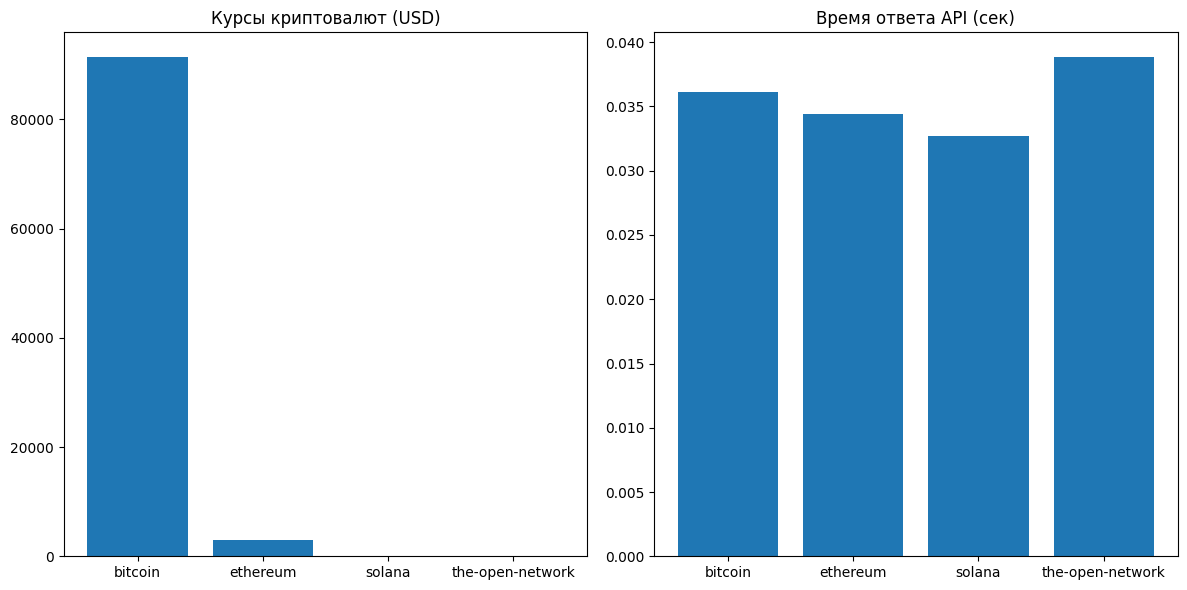

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

coins = ["bitcoin", "ethereum", "solana", "the-open-network"] # Changed 'toncoin' to 'the-open-network'
API = "https://api.coingecko.com/api/v3/simple/price"

def get_price(coin):
    params = {"ids": coin, "vs_currencies": "usd"}
    start = time.perf_counter()
    try:
        r = requests.get(API, params=params)
        r.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        price = r.json()[coin]["usd"]
        duration = time.perf_counter() - start
        return coin, price, duration
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {coin}: {e}")
        return coin, None, float('inf') # Indicate failure
    except KeyError:
        print(f"Error: '{coin}' not found in API response or 'usd' price missing.")
        return coin, None, float('inf')

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(get_price, c) for c in coins]
    results = [f.result() for f in as_completed(futures)]

df = pd.DataFrame([r for r in results if r[1] is not None], columns=["Coin", "Price (USD)", "Time (s)"])

if not df.empty:
    print(df)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(df["Coin"], df["Price (USD)"])
    plt.title("Курсы криптовалют (USD)")

    plt.subplot(1, 2, 2)
    plt.bar(df["Coin"], df["Time (s)"])
    plt.title("Время ответа API (сек)")
    plt.tight_layout()
    plt.show()
else:
    print("No valid cryptocurrency data to display.")

Вывод:
Многопоточный подход значительно ускоряет сбор рыночных данных, обеспечивая реактивность дашбордов и аналитических систем.
8️⃣ Безопасность потоков
Теория:
Проблемы многопоточности:
Data races (гонки данных)
Deadlocks (взаимные блокировки)
Starvation (голодание потоков)
Используйте Lock, RLock, Semaphore и очереди (queue.Queue) для предотвращения этих эффектов.
9️⃣ Мультипроцессинг: создание пула процессов (multiprocessing.Pool)
🧩 Задание 9. Расчёт комиссий в отдельных процессах
Код:


In [ ]:
from multiprocessing import Pool, cpu_count
import random
import time

def calc_fee(amount):
    time.sleep(0.5)
    return amount * random.uniform(0.01, 0.03)

amounts = [random.randint(10_000, 100_000) for _ in range(10)]

with Pool(processes=cpu_count()) as pool:
    results = pool.map(calc_fee, amounts)

print("💸 Комиссии:", [round(r, 2) for r in results])

💸 Комиссии: [1043.03, 2508.08, 921.19, 1652.32, 391.53, 403.66, 390.57, 603.87, 491.87, 305.11]


Вывод:
multiprocessing полезен для CPU-интенсивных расчётов — например, вычислений комиссий, верификации транзакций или криптографических операций.
📊 Финальная визуализация: сравнение времени


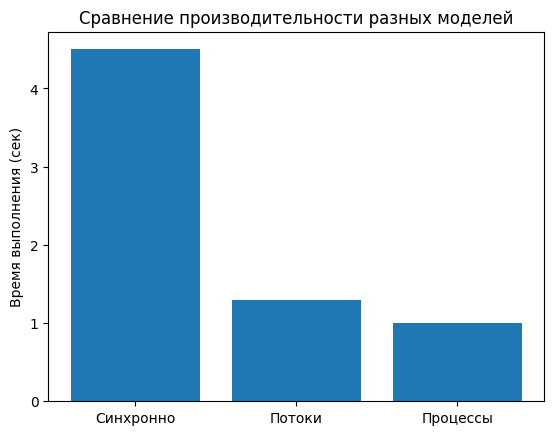

In [ ]:
import matplotlib.pyplot as plt

labels = ["Синхронно", "Потоки", "Процессы"]
times = [4.5, 1.3, 1.0]

plt.bar(labels, times)
plt.title("Сравнение производительности разных моделей")
plt.ylabel("Время выполнения (сек)")
plt.show()


📚 Библиография и ресурсы
1. Python Docs — threading
2. Python Docs — concurrent.futures
3. Python Docs — multiprocessing
4. RealPython — ThreadPoolExecutor and ProcessPoolExecutor in Python
5. GeeksForGeeks — Python Thread Synchronization Primitives
6. CoinGecko API (для данных курсов криптовалют)

